# 1 Setup

# 1.1 Read Packages

In [166]:
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy import sparse, linalg

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# 1.2 Read Data

In [167]:
df_FR = pd.read_csv('UMW_FR_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])
df_IT = pd.read_csv('UMW_IT_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])
df_ES = pd.read_csv('UMW_ES_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])

# 2 Data Preprocessing

# 2.1 Build Matrix A and M
Here each platform is a row in A

In [168]:
#Drop na and concatenate all the tables together
dfs_list = []
for d in [df_FR, df_IT, df_ES]:
    d['source'] = d['source'] + '_' + d['country_name']
    temp = d[['source', 'mama_movie_id']].dropna()
    temp['mama_movie_id'] = temp['mama_movie_id'].astype(int)
    dfs_list.append(temp)

df = pd.concat(dfs_list, axis=0)

In [169]:
#Create the sparse matrix
df['count'] = 1
df = pd.pivot_table(df, values='count', index=['source'], columns=['mama_movie_id'], aggfunc=np.sum, fill_value=0)
A = sparse.coo_matrix(df.values)

In [170]:
#Get the map between mama ids and original titles
dfs_list = []
for d in [df_FR, df_IT, df_ES]:
    temp = d[['original_title', 'mama_movie_id']].dropna()
    temp['mama_movie_id'] = temp['mama_movie_id'].astype(int)
    dfs_list.append(temp)
id_to_title = pd.concat(dfs_list, axis=0)
id_to_title = id_to_title.set_index('mama_movie_id').to_dict()['original_title']

# 2.2 Facts About A

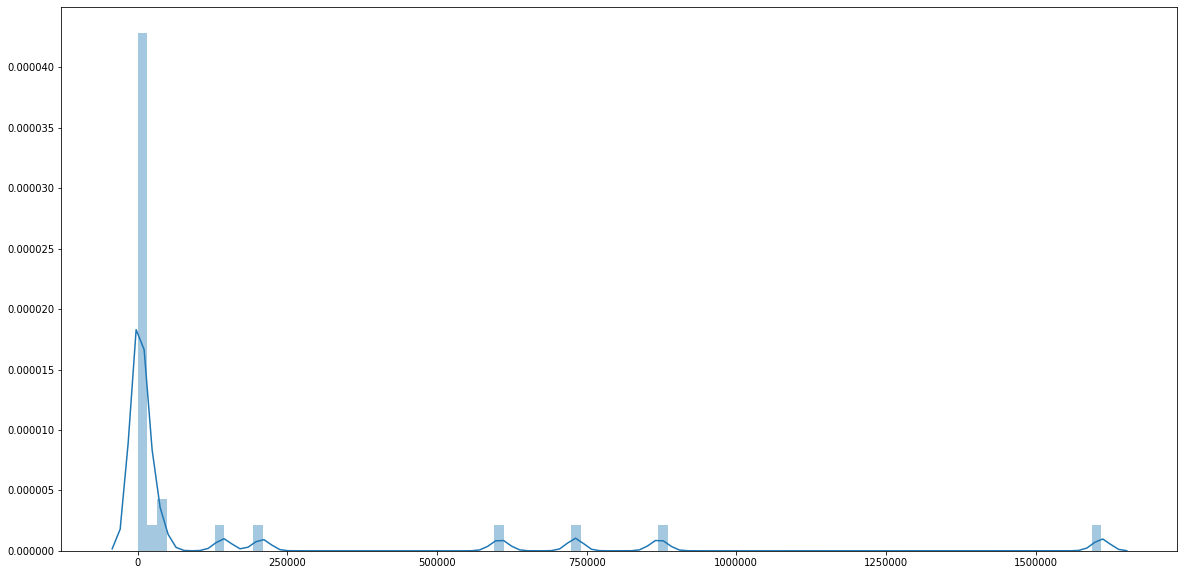

In [151]:
data = np.sum(A, axis=1)
fig, ax = plt.subplots(ncols=1, figsize=[20,10])

#The distribution of the number of movies watched by each user
g = sns.distplot(data, bins=100, ax=ax)

# 3 Collabrative Filtering

# 3.1 Modeling

In [171]:
model = LightFM(loss='warp', no_components=5, k=5)

# 3.2 Cross Validation

In [154]:
train, test = random_train_test_split(A, test_percentage=0.3)

In [155]:
model.fit(train, epochs=3000, num_threads=8)

In [156]:
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print('train_auc: ', train_auc)
print('test_auc: ', test_auc)

train_auc:  0.9984471
test_auc:  0.7404461


In [157]:
#Precision measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / k

train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()
print('train_precision: ', train_precision)
print('test_precision: ', test_precision)

train_precision:  0.63571435
test_precision:  0.016


In [158]:
#Recall measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / the number of movies that a customer has watched

train_recall = recall_at_k(model, train, k=5).mean()
test_recall = recall_at_k(model, test, k=5).mean()
print('train_recall: ', train_recall)
print('test_recall: ', test_recall)

train_recall:  0.15246827824235737
test_recall:  0.04181818181818182


# 3.3 Model Training

In [172]:
model.fit(A, epochs=3000, num_threads=8)

# 3.4 Customer Vectors and Movie Vectors

In [173]:
C_b, C = model.get_user_representations()
M_b, M = model.get_item_representations()

# 3.5 Predictions
Attention: for now I have not filtered out movies that have already been on the platform yet.

In [174]:
def recommendation(model, data, top_n=5):
    n_users, n_items = data.shape
    temp = np.zeros([n_users, top_n])
    for i in np.arange(n_users):
        scores = model.predict(i, np.arange(n_items))
        top_items = data.columns[np.argsort(-scores)][:top_n]
        temp[i,:] = top_items
    temp = pd.DataFrame(temp, dtype=int)
    temp.columns = ['Top_' + str(c+1) for c in temp.columns]
    temp = temp.replace(id_to_title)
    
    result = pd.DataFrame({'source_country': df.index})
    result = pd.concat([result, temp], axis = 1)
    
    return result

In [175]:
recommendation(model, df, top_n=5)

,source_country,Top_1,Top_2,Top_3,Top_4,Top_5
0,arte_France,The Escort,Ferrari 312B: Where the revolution begins,Prank,Mala Mala,To mikro psari
1,canal vod_France,Goodbye World,Moonwalkers,The Escort,Les Pee-Wee 3D: L'hiver qui a changé ma vie,Love and Honor
2,filmin_Spain,Le magasin des suicides,The Escort,Nicht mein Tag,Lou! Journal infime,Je compte sur vous
3,google_France,Goodbye World,Moonwalkers,Three Night Stand,The Loner,Free Ride
4,google_Italy,Ferrari 312B: Where the revolution begins,"Extremely Wicked, Shockingly Evil and Vile",The Last Prosecco,The Program,La belle et la bÃªte
5,google_Spain,Dalida,Papa ou Maman 2,Ange et Gabrielle,Koza,Wallay
6,itunes_France,La Reina de España,Tapis rouge,"Literally, Right Before Aaron",Bad Match,The Case for Christ
7,itunes_Italy,Les derniers parisiens,Noces,Swagger,Fleuve noir,"Ni juge, ni soumise"
8,itunes_Spain,Dalida,10x10,First Kill,Acts of Violence,Dark Crimes
9,microsoft_France,Moonwalkers,Goodbye World,Les Pee-Wee 3D: L'hiver qui a changé ma vie,Almost Friends,Love and Honor
